Assumes trained MaskRCNN that provides instance segmentations of boxes is available, from e.g. keypoint mcmc notebook.

Also assumes a trained dense descriptor network of boxes is available.

In [1]:
%load_ext autoreload
%autoreload 2

import community as community_louvain
from copy import deepcopy
from collections import OrderedDict
import cv2
import copy
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import point_cloud_utils as pcu
import torch
import torch.nn.functional as F
from skimage.transform import resize
from skimage.color import rgb2gray
import tqdm

import torch
import torchvision

import dense_correspondence_manipulation.utils.utils as utils

import meshcat
import meshcat.geometry as g

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.datasets import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads
from scene_generation.inverse_graphics.keypoint_mcmc.particle_filter_icp import *

np.set_printoptions(precision=2)
torch.set_default_tensor_type(torch.FloatTensor)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"


class InstanceCloud():
    def __init__(self, pts, colors, descriptors):
        self.pts = pts
        self.descriptors = descriptors
        self.colors = colors
    def get_augmented_pts(self, descriptor_factor=1.):
        return np.vstack([self.pts, descriptor_factor*self.descriptors])
    
%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

print(torchvision.__file__)

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torchvision-0.6.0a0+fb562f5-py3.6-linux-x86_64.egg/torchvision/__init__.py


In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from scene_generation.inverse_graphics.synthetic_scene_database_loader import load_xencoco_json

DatasetCatalog.clear()
def load_dataset(d):
    return load_xencoco_json(
        os.path.join(DATA_ROOT, "%s.json" % (d)),
        data_root=DATA_ROOT,
        dataset_name="synthetic_%s" % d)
def load_real_dataset():
    return load_coco_json(
        "/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json",
        image_root="/home/gizatt/data/coco/cardboard_boxes_in_wild/images",
        dataset_name="prime_boxes_real", extra_annotation_keys=None)
for d in ["train", "test"]:
    DatasetCatalog.register("synthetic_" + d, lambda d=d: load_dataset(d))
DatasetCatalog.register("prime_boxes_real", load_real_dataset)
synthetic_train_metadata = MetadataCatalog.get("synthetic_train")
real_prime_boxes_metadata = MetadataCatalog.get("prime_boxes_real")
real_prime_boxes_metadata.set(json_file="/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json")
print("Metadata train: ", synthetic_train_metadata)
print("Metadata real: ", real_prime_boxes_metadata)
DatasetCatalog.register("synthetic_5_types", lambda: load_dataset("scene_groups_5_types"))

Metadata train:  Metadata(name='synthetic_train')
Metadata real:  Metadata(json_file='/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json', name='prime_boxes_real')


In [3]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(DETECTRON_ROOT, "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.INPUT.MIN_SIZE_TRAIN = (480)
cfg.INPUT.MIN_SIZE_TEST = (480)
cfg.INPUT.DEPTH_FORMAT = 'L'
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.DATASETS.TRAIN = ("synthetic_train",)
cfg.DATASETS.TEST = ("synthetic_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"

#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# Start from pre-trained on just detections
#base_weight_dir = "notebooks/output/keypoint_cmcm/maskrcnn_base_without_heatmap_padded_boxes_1/"
#base_weight_dir = "output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax/"
base_weight_dir = "output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax_fine_tuning/"
cfg.MODEL.WEIGHTS = os.path.join(base_weight_dir, "model_final.pth")

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (prime box)
#cfg.MODEL.ROI_HEADS.NAME = "KeypointMCMCROIHeads"

test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))

In [4]:
model = build_model(cfg)
model.eval()

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 GeForce GTX 680 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [5]:
# Load in descriptor network
from dense_correspondence.network.dense_correspondence_network import DenseCorrespondenceNetwork
from scene_generation.inverse_graphics.supervised_dense_descriptors.labeled_descriptors_dataset import LabeledDescriptorsDataset
from scene_generation.inverse_graphics.supervised_dense_descriptors.evaluation import SupervisedDescriptorEvaluation
import yaml
import dense_correspondence_manipulation.utils.utils as utils

# Need a dummy dataset for data normalization it provides
root = "/home/gizatt/projects/scene_generation/inverse_graphics/supervised_dense_descriptors/"
data_config_filename = "dataset_config.yaml"
data_config = utils.getDictFromYamlFilename(os.path.join(root, data_config_filename))
dataset = LabeledDescriptorsDataset(data_config, debug=False)
eval_config_filename = "evaluation_config.yaml"
eval_config = utils.getDictFromYamlFilename(os.path.join(root, eval_config_filename))
sce = SupervisedDescriptorEvaluation(config=eval_config,
                                     dataset=dataset)
dcn = sce.load_network_from_config("test_run_updated_torch")

Using SyntheticCorrespondenceDataset:
   - in train mode
   - total images:     2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.1000, 0.1500, 0.1800],
        [0.2500, 0.1000, 0.1000],
        [0.2500, 0.1000, 0.1000],
        [0.2500, 0.1000, 0.1000],
        [0.1000, 0.1500, 0.1800]])
tensor([[-0.0970,  0.3922,  1.2376],
        [ 0.0576, -0.0365,  0.9279],
        [ 0.2350,  0.2869,  1.0455],
        [-0.3304, -0.1153,  1.0942],
        [-0.0842,  0.1378,  0.8591]])


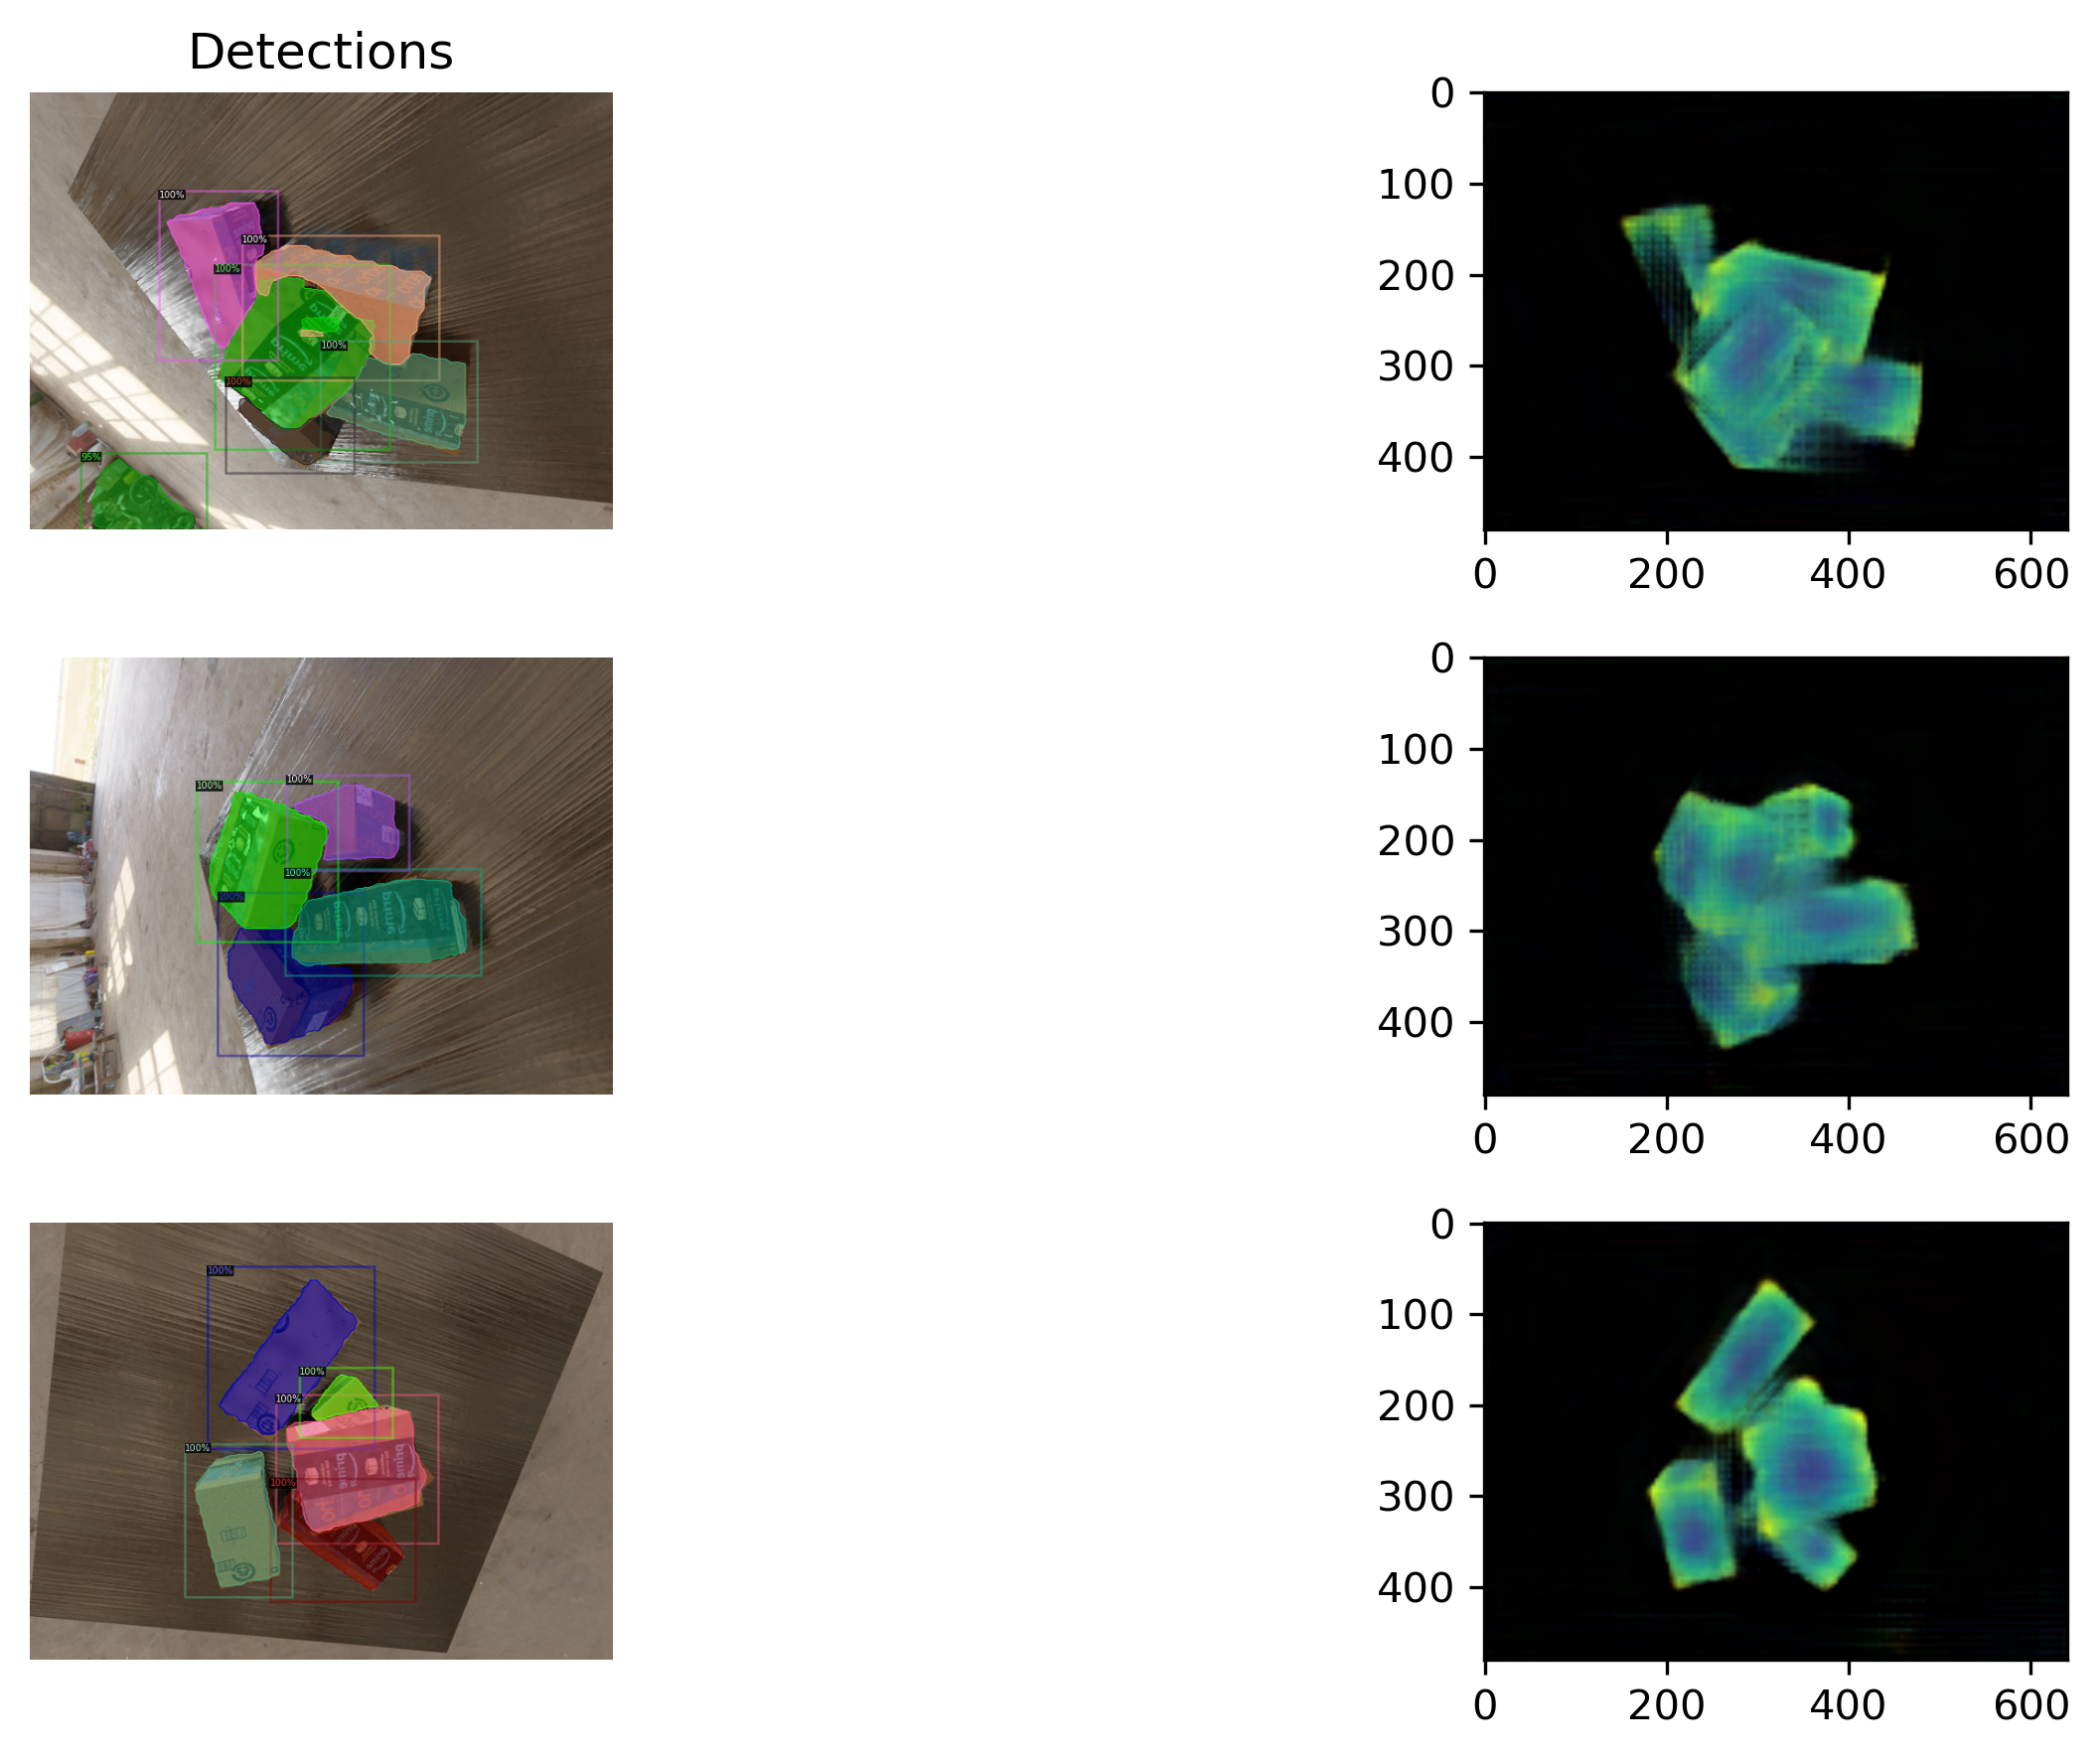

In [432]:
height_to_show = 3
plt.figure(dpi=300).set_size_inches(12, 6)

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))
test_loader_iterator = iter(test_loader)
test_metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])
all_examples = [next(test_loader_iterator)[0] for k in range(40)]
examples = all_examples[15:(15+height_to_show)]
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    #inputs = {"image": image, "height": height, "width": width}
    predictions = model(examples)
    for k, pred in enumerate(predictions):
        im = examples[k]["image"].detach().cpu().numpy().copy().transpose([1, 2, 0])
        # Pass through for descriptor image
        pred_descriptor_im = sce.evaluate_image(dcn, im/255.)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        v = Visualizer(
                im,
                metadata=test_metadata, 
                scale=1)
        v = v.draw_instance_predictions(pred["instances"].to("cpu"))
        im_rgb = v.get_image()[:, :, ::-1]
        plt.subplot(height_to_show, 2, 2*k+1)
        if k == 0:
            plt.title("Detections")
        cv2_imshow(im_rgb)
        plt.subplot(height_to_show, 2, 2*k+2)
        plt.imshow(pred_descriptor_im, vmin=0., vmax=1.)
plt.tight_layout()
print(examples[0]["instances"].gt_shape_params)
print(examples[0]["instances"].gt_pose_quatxyz[:, -3:])

In [539]:
# Preload all examples (cpu-side), and group by views into the same physical scene
torch.multiprocessing.set_sharing_strategy('file_system')
test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_5_types", mapper=XenRCNNMapper(cfg, True))
all_examples = []
for batch_ndx, sample in enumerate(test_loader):
    all_examples += sample
        
example_inds_by_scene_and_subscene_ind = {}
for example_k, example in enumerate(all_examples):
    record = (example["scene_id"], example["subscene_id"])
    if record not in example_inds_by_scene_and_subscene_ind.keys():
        example_inds_by_scene_and_subscene_ind[record] = []
    example_inds_by_scene_and_subscene_ind[record].append(example_k)

In [541]:
# Draw a single perspective's point cloud
# Extract all of the point cloud bits for each scene
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.delete()

example = all_examples[1]
        
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    prediction = model([example])[0]
    im = example["image"].detach().cpu().numpy().copy().transpose([1, 2, 0])
    pred_descriptor_im = torch.tensor(sce.evaluate_image(dcn, im/255.)).permute(2, 0, 1)

K = example["K"]
cam_pose = example["camera_pose"]
cam_R = quat2mat(torch.tensor(cam_pose[:4]).unsqueeze(0))[0].T
cam_t = torch.tensor(cam_pose[-3:])

full_rgb_im = example["image"].cpu().flip(dims=(0,))
full_depth_im = example["depth_image"][0].cpu()
# Pre-generate the entire point cloud
depth_X, depth_Y = torch.meshgrid(
    (torch.arange(full_depth_im.shape[0]),
     torch.arange(full_depth_im.shape[1])))
full_pointcloud = torch.stack([depth_Y.float(), depth_X.float(), full_depth_im], dim=0)
# Convert to 3D coordinates by inverting projection operation
full_pointcloud[0, ...] = (full_pointcloud[0, ...] - K[0, 2]) * (full_pointcloud[2, ...] / K[0, 0])
full_pointcloud[1, ...] = (full_pointcloud[1, ...] - K[1, 2]) * (full_pointcloud[2, ...] / K[1, 1])

# Apply the camera pose
full_pointcloud = (torch.matmul(full_pointcloud.transpose(2, 0), cam_R) + cam_t).transpose(2, 0)

instance_clouds = []
for instance_k in range(len(prediction["instances"])):
    instance = prediction["instances"][instance_k]

    # Get the segmented point cloud for this object
    bbox_int = instance.pred_boxes.tensor.cpu().detach().flatten().int()
    sub_pointcloud = full_pointcloud[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
    sub_rgb = full_rgb_im[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
    sub_desc = pred_descriptor_im[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
    mask = instance.pred_masks[0, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]].cpu()
    assert mask.shape == sub_pointcloud.shape[1:], (mask.shape, sub_pointcloud.shape)
    in_range_mask = (sub_pointcloud[2, ...] < 3.) * (sub_pointcloud[2, ...] > 0.1)
    full_mask = (mask.flatten() * in_range_mask.flatten()) > 0
    pts = sub_pointcloud.reshape(3, -1)[:, full_mask]
    colors = sub_rgb.reshape(3, -1)[:, full_mask] / 255.
    descriptors = sub_desc.reshape(3, -1)[:, full_mask]
    if pts.shape[1] > 0:
        instance_clouds.append(InstanceCloud(pts, colors, descriptors))

# Draw it
vis["debug"].delete()
for k, cloud in enumerate(instance_clouds[1:2]):
    pts = cloud.pts.numpy()[:, :]
    colors = cloud.colors.numpy()[:, :]
    #color = np.random.random(3)
    #colors = np.tile(color[:, np.newaxis], [1, pts.shape[1]])
    vis["debug/observed_%02d" % k].set_object(
        g.PointCloud(position=pts,
                     color=colors,
                     size=0.005))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Now we need to do something tricky: we'll take the detections of the same physical scene (same object arrangement), extract all of the instance detection point clouds from each, and try to group them into object detections across images. The goal is to get multi-view point clouds of each object to run our particle-filter-ICP shape inference against.

In [542]:
import tqdm

# Extract all of the point cloud bits for each scene
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.delete()

def get_all_instance_pointclouds_for_record(record_id):
    example_inds = example_inds_by_scene_and_subscene_ind[record_id]
    out = []
    for example_k in example_inds:
        example = all_examples[example_k]
        
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            prediction = model([example])[0]
            im = example["image"].detach().cpu().numpy().copy().transpose([1, 2, 0])
            pred_descriptor_im = torch.tensor(sce.evaluate_image(dcn, im/255.)).permute(2, 0, 1)

        K = example["K"]
        cam_pose = example["camera_pose"]
        cam_R = quat2mat(torch.tensor(cam_pose[:4]).unsqueeze(0))[0].T
        cam_t = torch.tensor(cam_pose[-3:])
        
        full_rgb_im = example["image"].cpu().flip(dims=(0,))
        full_depth_im = example["depth_image"][0].cpu()
        # Pre-generate the entire point cloud
        depth_X, depth_Y = torch.meshgrid(
            (torch.arange(full_depth_im.shape[0]),
             torch.arange(full_depth_im.shape[1])))
        full_pointcloud = torch.stack([depth_Y.float(), depth_X.float(), full_depth_im], dim=0)
        # Convert to 3D coordinates by inverting projection operation
        full_pointcloud[0, ...] = (full_pointcloud[0, ...] - K[0, 2]) * (full_pointcloud[2, ...] / K[0, 0])
        full_pointcloud[1, ...] = (full_pointcloud[1, ...] - K[1, 2]) * (full_pointcloud[2, ...] / K[1, 1])

        # Apply the camera pose
        full_pointcloud = (torch.matmul(full_pointcloud.transpose(2, 0), cam_R) + cam_t).transpose(2, 0)
        
        for instance_k in range(len(prediction["instances"])):
            instance = prediction["instances"][instance_k]

            # Get the segmented point cloud for this object
            bbox_int = instance.pred_boxes.tensor.cpu().detach().flatten().int()
            sub_pointcloud = full_pointcloud[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
            sub_rgb = full_rgb_im[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
            sub_desc = pred_descriptor_im[:, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]]
            mask = instance.pred_masks[0, bbox_int[1]:bbox_int[3], bbox_int[0]:bbox_int[2]].cpu()
            assert mask.shape == sub_pointcloud.shape[1:], (mask.shape, sub_pointcloud.shape)
            in_range_mask = (sub_pointcloud[2, ...] < 3.) * (sub_pointcloud[2, ...] > 0.1)
            full_mask = (mask.flatten() * in_range_mask.flatten()) > 0
            pts = sub_pointcloud.reshape(3, -1)[:, full_mask]

            colors = sub_rgb.reshape(3, -1)[:, full_mask] / 255.
            descriptors = sub_desc.reshape(3, -1)[:, full_mask]
            if pts.shape[1] > 0:
                out.append(InstanceCloud(pts, colors, descriptors))
    return out

def apply_cluster_cleanup(cluster):
    import open3d as o3d
    # Apply Open3d voxel grid filtering to it
    scene_o3d = o3d.geometry.PointCloud()
    scene_o3d.points = o3d.utility.Vector3dVector(cluster.pts.T.numpy().copy())
    # Pass through inds as colors to get the downsampling info
    scene_o3d.colors = o3d.utility.Vector3dVector(np.tile(np.arange(cluster.pts.shape[1])[:, np.newaxis], [1, 3]))
    scene_o3d.estimate_normals()
    scene_o3d_filtered, ind = scene_o3d.remove_statistical_outlier(
        nb_neighbors=40, std_ratio=1.0)
    # And downsample some
    scene_o3d_filtered = scene_o3d_filtered.voxel_down_sample(0.005)
    cluster.pts = torch.tensor(np.asarray(scene_o3d_filtered.points).T.copy(), dtype=cluster.pts.dtype)
    downselect_inds = np.asarray(scene_o3d_filtered.colors)[:, 0].T.astype(int)
    cluster.descriptors = cluster.descriptors[:, downselect_inds]
    cluster.colors = cluster.colors[:, downselect_inds]
    return cluster

test_records_to_analyze = list(example_inds_by_scene_and_subscene_ind.keys())[:20]
all_instance_clouds_by_record = {}
for test_record in tqdm.tqdm(test_records_to_analyze):
    pre_filtered_instance_clouds = get_all_instance_pointclouds_for_record(test_record)
    all_instance_clouds = []
    for cluster in pre_filtered_instance_clouds:
        cluster = apply_cluster_cleanup(cluster)
        if cluster.pts.shape[1] > 1000:
            all_instance_clouds.append(cluster)
    all_instance_clouds_by_record[test_record] = all_instance_clouds
    # Draw it
    vis["debug"].delete()
    for k, cloud in enumerate(all_instance_clouds):
        pts = cloud.pts.numpy()
        colors = cloud.colors.numpy()
        #colors = cloud.descriptors.numpy()
        #color = np.random.random(3)
        #colors = np.tile(color[:, np.newaxis], [1, pts.shape[1]])
        vis["debug/observed_%02d" % k].set_object(
            g.PointCloud(position=pts,
                         color=colors, #cloud.descriptors[:, ::10].numpy(),
                         size=0.005))

  0%|          | 0/20 [00:00<?, ?it/s]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


100%|██████████| 20/20 [01:50<00:00,  5.55s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

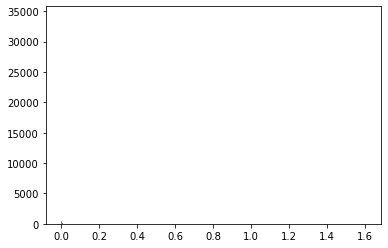

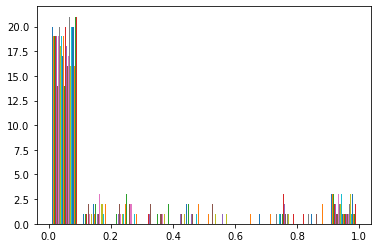

  5%|▌         | 1/20 [00:11<03:41, 11.64s/it]

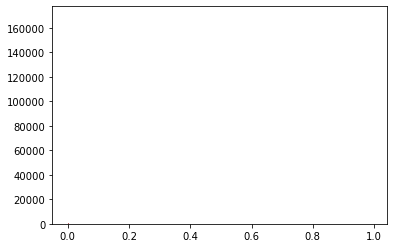

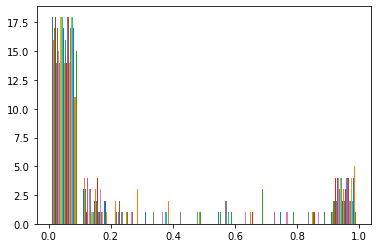

 10%|█         | 2/20 [00:24<03:33, 11.89s/it]

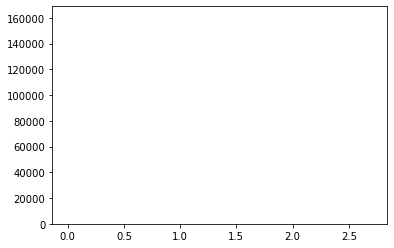

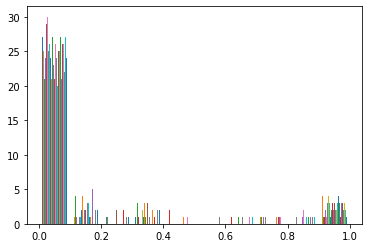

 15%|█▌        | 3/20 [00:45<04:10, 14.76s/it]

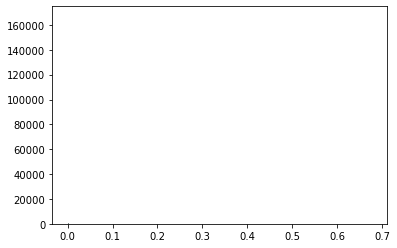

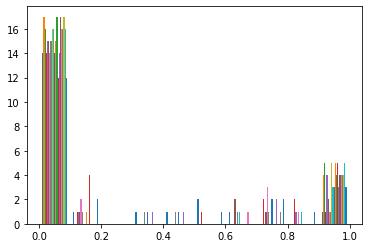

 20%|██        | 4/20 [00:56<03:36, 13.51s/it]

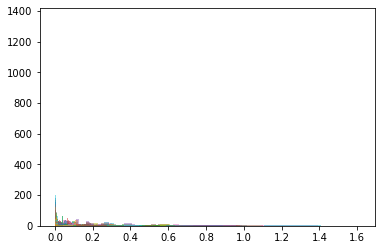

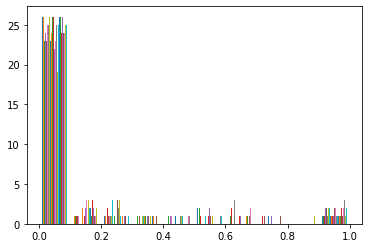

 25%|██▌       | 5/20 [01:17<03:58, 15.88s/it]

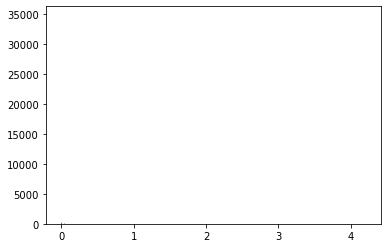

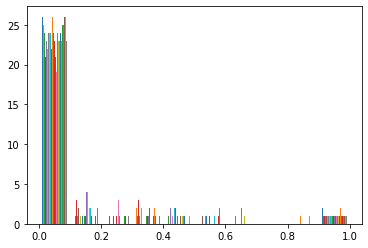

 30%|███       | 6/20 [01:38<04:01, 17.26s/it]

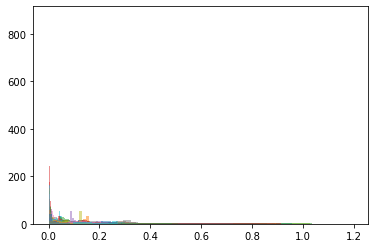

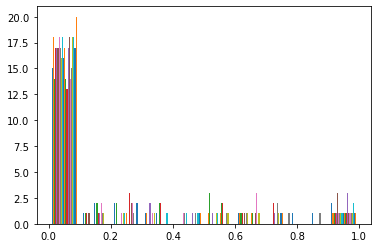

 35%|███▌      | 7/20 [01:49<03:20, 15.45s/it]

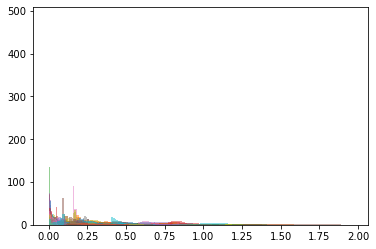

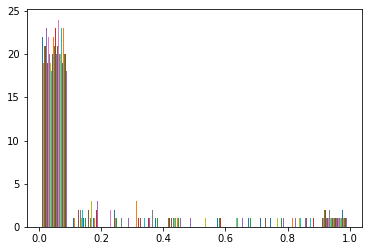

 40%|████      | 8/20 [02:01<02:53, 14.45s/it]

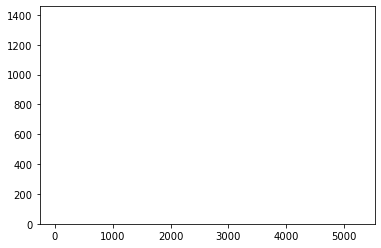

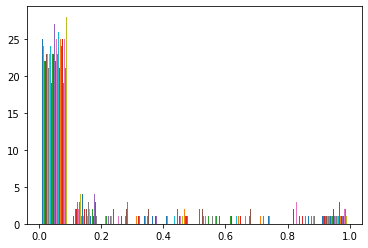

 45%|████▌     | 9/20 [02:16<02:42, 14.76s/it]

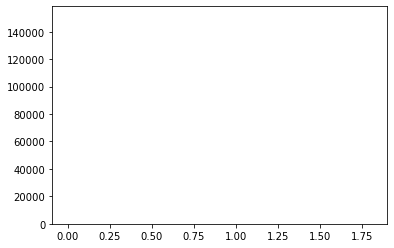

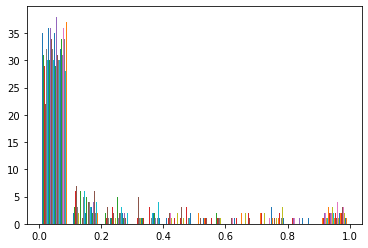

 50%|█████     | 10/20 [02:51<03:26, 20.66s/it]

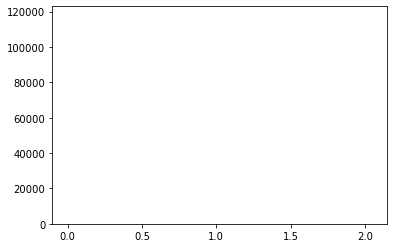

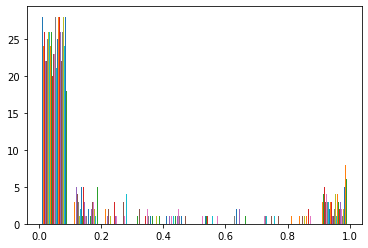

 55%|█████▌    | 11/20 [03:18<03:23, 22.57s/it]

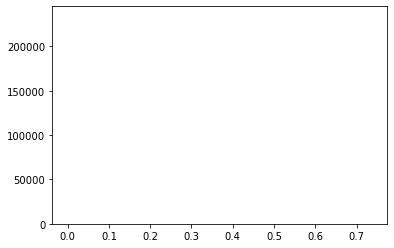

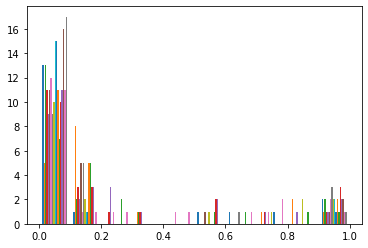

 60%|██████    | 12/20 [03:22<02:16, 17.03s/it]

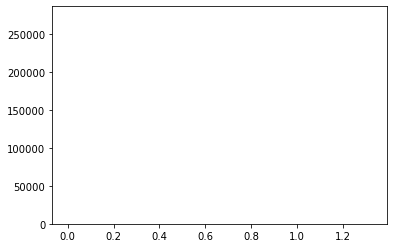

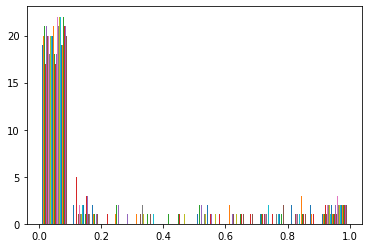

 65%|██████▌   | 13/20 [03:41<02:02, 17.50s/it]

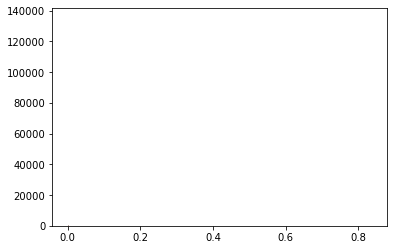

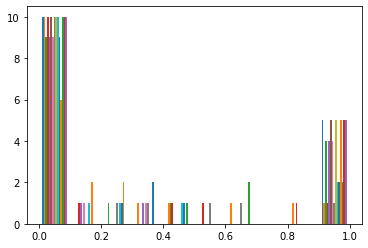

 70%|███████   | 14/20 [03:43<01:18, 13.12s/it]

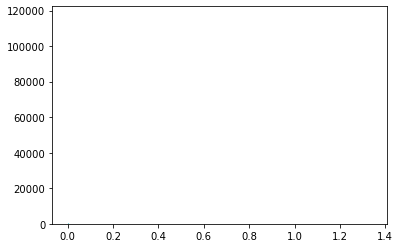

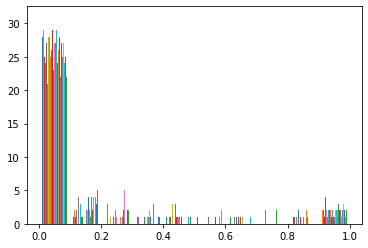

 75%|███████▌  | 15/20 [04:06<01:19, 15.81s/it]

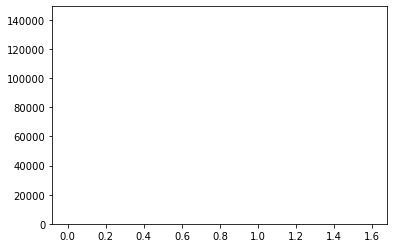

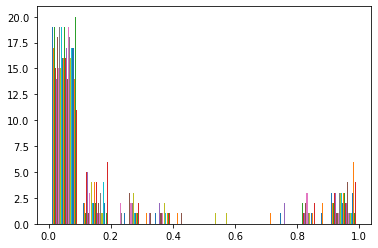

 80%|████████  | 16/20 [04:18<00:58, 14.68s/it]

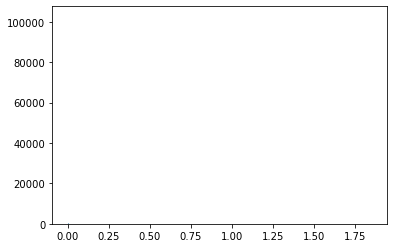

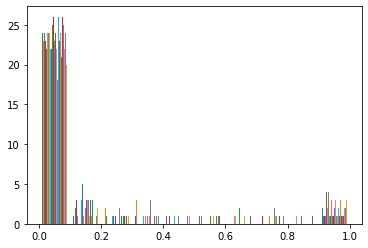

 85%|████████▌ | 17/20 [04:37<00:48, 16.04s/it]

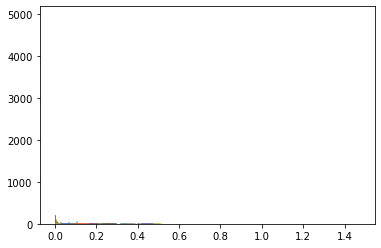

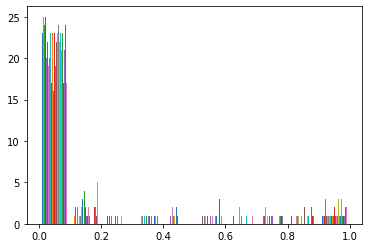

 90%|█████████ | 18/20 [04:51<00:30, 15.48s/it]

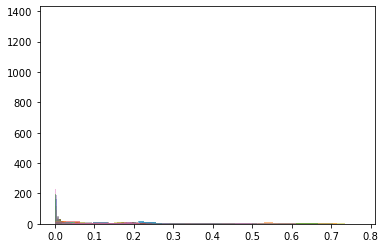

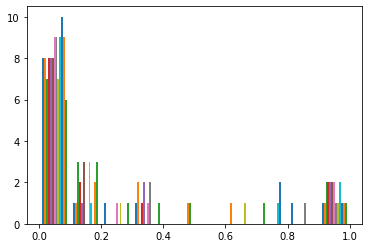

 95%|█████████▌| 19/20 [04:53<00:11, 11.48s/it]

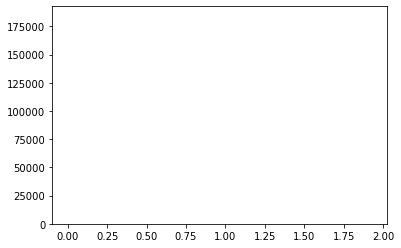

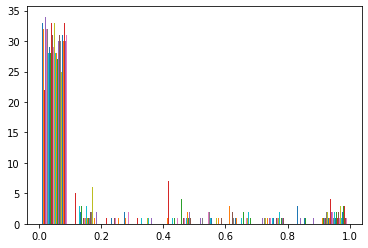

100%|██████████| 20/20 [05:24<00:00, 16.22s/it]


In [543]:
%matplotlib inline
# Now that we have all of the subclouds, compute an overlap
# metric between them -- the # of point pairs that are below a threshold
# distance.
def compute_affinities_for_instance_clouds(instance_clouds):
    distance_threshold = 0.005
    alpha = 1.0
    num_clouds = len(instance_clouds)
    affinities = np.zeros((num_clouds, num_clouds))
    for k_1, cloud_1 in enumerate(instance_clouds):
        for k_2, cloud_2 in enumerate(instance_clouds):
            if k_1 > k_2:
                continue
            if k_1 == k_2:
                affinities[k_1, k_2] = 1.
            else:
                dists_a_to_b, corrs_a_to_b = pcu.point_cloud_distance(cloud_1.pts.numpy().T, cloud_2.pts.numpy().T)
                # Compute descriptor distances as affinity
                descriptor_dists = np.linalg.norm(cloud_2.descriptors[:, corrs_a_to_b] - cloud_1.descriptors, axis=0)
                total_dists = dists_a_to_b*alpha + descriptor_dists*(1. - alpha)
                plt.hist(total_dists, density=True, label="%d_%d" % (k_1, k_2), alpha=0.5)
                affinity = float(np.mean(total_dists < distance_threshold))
                affinities[k_1, k_2] += affinity
                affinities[k_2, k_1] += affinity
    plt.show()
    return affinities

def compute_clusters_from_affinities(instance_clouds, affinities):
    G = nx.from_numpy_matrix(affinities)
    partition = community_louvain.best_partition(G)

    vis["debug"].delete()
    n_comps = max(list(partition.values()))
    clusters = []
    for cluster_k in range(n_comps):
        pts = []
        colors = []
        descriptors = []
        for l in range(len(instance_clouds)):
            if partition[l] == cluster_k:
                pts.append(instance_clouds[l].pts)
                colors.append(instance_clouds[l].colors)
                descriptors.append(instance_clouds[l].descriptors)
        num_in_cluster = len(pts)

        cluster = InstanceCloud(
            torch.cat(pts, dim=1),
            torch.cat(colors, dim=1),
            torch.cat(descriptors, dim=1))
        clusters.append(cluster)

        pts = torch.cat(pts, dim=1)
        color = np.random.random(3)
        colors = np.tile(color[:, np.newaxis], [1, pts.shape[1]])
        vis["debug/observed_%02d" % cluster_k].set_object(
            g.PointCloud(position=pts.numpy(),
                         color=colors,
                         size=0.02))
    return clusters

affinities_by_record = {}
clusters_by_record = {}
for test_record in tqdm.tqdm(list(all_instance_clouds_by_record.keys())):
    instance_clouds = all_instance_clouds_by_record[test_record]
    affinities = compute_affinities_for_instance_clouds(instance_clouds)
    plt.hist(affinities)
    plt.show()
    affinities[affinities < 0.5] = 0.
    clusters = compute_clusters_from_affinities(instance_clouds, affinities)
    affinities_by_record[test_record] = affinities
    clusters_by_record[test_record] = clusters

In [544]:
torch.save(
    {"all_instance_clouds_by_record": all_instance_clouds_by_record,
     "affinities_by_record": affinities_by_record,
     "clusters_by_record": clusters_by_record},
    "run_on_all_records.pt")

In [545]:
load_dict = torch.load("run_on_all_records.pt")
all_instance_clouds_by_record = load_dict["all_instance_clouds_by_record"]
affinities_by_record = load_dict["affinities_by_record"]
clusters_by_record = load_dict["clusters_by_record"]

In [546]:
# Drawing a clustered scene, for review
test_record = list(clusters_by_record.keys())[0]
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.delete()
print(len(clusters_by_record[test_record]))
for cluster_k, cluster in enumerate(clusters_by_record[test_record]):
    pts = cluster.pts
    color = np.random.random(3)
    colors = np.tile(color[:, np.newaxis], [1, pts.shape[1]])
    #colors = cluster.colors.numpy()
    vis["debug/observed_%02d" % cluster_k].set_object(
        g.PointCloud(position=pts.numpy(),
                     color=colors,
                     size=0.01))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
8


In [547]:
clusters = []
for c in list(clusters_by_record.values()):
    clusters += c

vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")["pure_pointcloud"]
vis.delete()
print("Analyzing %d clusters" % len(clusters))

def compute_unit_box_descriptors(pts, normals):
    # Descriptor is the viridis color coding
    # of the distance to the center of each pt's face.
    face_local = np.abs(pts)*(normals == 0.0)*2
    dist = np.linalg.norm(face_local, axis=0)/1.414
    return torch.tensor(cm.get_cmap('viridis')(dist).astype(np.float32).T[:3, :])
    
# Finally, take a cluster + do ICP on it
model_pts, model_normals = make_unit_box_pts_and_normals(N=500)
model_colors = np.zeros((3, model_pts.shape[1]))
model_colors[0, :] = 1.
model_descriptors = compute_unit_box_descriptors(model_pts, model_normals)
#vis["model_descriptors"].set_object(
#    g.PointCloud(position=model_pts.numpy(),
#                 color=model_descriptors.numpy(),
#                 size=0.05))
vis["debug"].delete()
icp = ParticleFilterIcp(
    model_pts=model_pts,
    model_normals=model_normals,
    model_descriptors=model_descriptors,
    descriptor_scaling=0.00,
    keep_ratio=0.8,
    top_N=1,
    min_corresp_distance=0.05,
    num_particles = 20,
    resample_thresh=0,
    vis=None) #vis=vis["icp_internal"])

all_cluster_indices = []
all_scores = []
all_Ss = []
all_Rs = []
all_ts = []

def do_pf_icp_on_cluster(cluster, cluster_index):
    global all_cluster_indices

    pts = cluster.pts
    colors = cluster.colors
    descriptors = cluster.descriptors

    desired_num_pts = 250

    # Subsample
    subsample_amount = max(1, int(pts.shape[1] / desired_num_pts))
    scene_pts = pts[:, ::subsample_amount]
    colors = colors[:, ::subsample_amount]
    scene_descriptors = descriptors[:, ::subsample_amount]

    vis["debug/observed"].set_object(
        g.PointCloud(position=scene_pts.numpy(),
                     color=colors.numpy(),
                     size=0.02))

    all_particle_history = []
    icp._reset_particles(scene_pts)
    for k in range(10):
        for j in range(100):
            icp._do_process_update(scene_pts, scene_descriptors)
            icp.particles.draw(vis["model"], model_pts, size=0.005)
            scores = icp._score_current_particles(scene_pts, scene_descriptors)
            all_particle_history.append((scores, deepcopy(icp.particles)))
        icp._do_resampling(scene_pts, scene_descriptors)


    for score, particle in all_particle_history:
        all_Rs.append(particle.R)
        all_ts.append(particle.t)
        all_Ss.append(particle.S)
        all_scores.append(score)
        all_cluster_indices += [cluster_index] * len(score)

for k, cluster in enumerate(tqdm.tqdm(clusters)):
    do_pf_icp_on_cluster(cluster, k)

all_Rs = torch.cat(all_Rs, dim=0)
all_ts = torch.cat(all_ts, dim=0)
all_Ss = torch.cat(all_Ss, dim=0)
all_scores = torch.cat(all_scores, dim=0)

  0%|          | 0/172 [00:00<?, ?it/s]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Analyzing 172 clusters


100%|██████████| 172/172 [3:54:22<00:00, 81.76s/it]  


In [548]:
# Save out runs so I don't lose them
torch.save(
    {"all_Rs": all_Rs,
     "all_ts": all_ts,
    "all_Ss": all_Ss,
    "all_scores": all_scores,
    "all_cluster_indices": all_cluster_indices},
    "pf_icp_runs.pt")

In [565]:
load_dict = torch.load("pf_icp_runs.pt")
all_Rs = load_dict["all_Rs"]
all_ts = load_dict["all_ts"]
all_Ss = load_dict["all_Ss"]
all_scores = load_dict["all_scores"]
all_cluster_indices = torch.tensor(load_dict["all_cluster_indices"])

Num kept:  80880


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


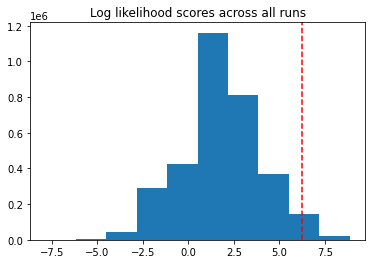

In [566]:
%matplotlib inline
# Normalize scores
#all_scores -= torch.logsumexp(all_scores, dim=0)
# Downselect to those entries with reasonable scores
plt.figure()
plt.hist(all_scores)
plt.title("Log likelihood scores across all runs")
keep_samples = min(250000, len(all_scores))
keep_thresh = torch.sort(all_scores)[0][-keep_samples]
#keep_thresh = 0.
plt.axvline(x=keep_thresh, color="red", linestyle="--")
keep_mask = all_scores > keep_thresh
useful_Rs = all_Rs[keep_mask]
useful_ts = all_ts[keep_mask]
useful_Ss = all_Ss[keep_mask]
useful_scores = all_scores[keep_mask]
useful_cluster_indices = torch.tensor(all_cluster_indices)[keep_mask]
print("Num kept: ", torch.sum(keep_mask).item())

  1%|          | 2/171 [00:00<00:09, 18.74it/s]

Max:  tensor(171)


100%|██████████| 171/171 [00:08<00:00, 19.08it/s]

Have  33211


(array([1420., 4278., 2614., 2043., 4079., 4361., 5014., 5207., 3174.,
        1021.]),
 array([1.64, 2.36, 3.09, 3.81, 4.53, 5.26, 5.98, 6.7 , 7.43, 8.15, 8.87],
       dtype=float32),
 <a list of 10 Patch objects>)

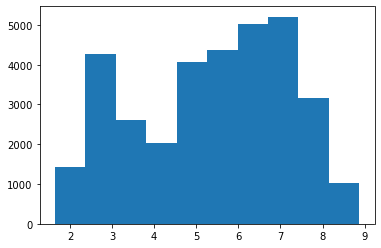

In [593]:
# Alternative: take the top 100 from each cluster
useful_Rs = []
useful_Ts = []
useful_Ss = []
useful_scores = []
useful_cluster_indices = []
max_cluster_index = torch.max(all_cluster_indices)
print("Max: ", max_cluster_index)
finite_mask = torch.isfinite(all_scores)
for cluster_k in tqdm.tqdm(range(max_cluster_index)):
    these_inds = torch.logical_and(all_cluster_indices == cluster_k, finite_mask)
    if torch.sum(these_inds) == 0:
        continue
    # Take the top 100 of this cluster + fit Multivariate gaussian to it
    these_scores = all_scores[these_inds]
    best_score_inds = torch.argsort(these_scores)[-200:]
    useful_Rs.append(all_Rs[these_inds][best_score_inds])
    useful_Ts.append(all_ts[these_inds][best_score_inds])
    useful_Ss.append(all_Ss[these_inds][best_score_inds])
    useful_scores.append(all_scores[these_inds][best_score_inds])
    useful_cluster_indices.append(all_cluster_indices[these_inds][best_score_inds])
useful_Rs = torch.cat(useful_Rs, dim=0)
useful_Ts = torch.cat(useful_Ts, dim=0)
useful_Ss = torch.cat(useful_Ss, dim=0)
useful_scores = torch.cat(useful_scores, dim=0)
useful_cluster_indices = torch.cat(useful_cluster_indices, dim=0)
print("Have ", len(useful_scores))
plt.hist(useful_scores.numpy())

In [594]:
# Draw the best particles
best_score_inds = torch.argsort(useful_scores)[-100:]
print(useful_scores[best_score_inds])
vis["best"].delete()
R = useful_Rs[best_score_inds]
t = useful_ts[best_score_inds]
S = useful_Ss[best_score_inds]
particle = ParticleFilterIcp_Particles(S, t, R)
particle.draw(vis["best"], model_pts, size=0.01)

tensor([8.5288, 8.5304, 8.5306, 8.5318, 8.5319, 8.5326, 8.5327, 8.5339, 8.5345,
        8.5347, 8.5352, 8.5399, 8.5404, 8.5414, 8.5415, 8.5425, 8.5428, 8.5437,
        8.5440, 8.5443, 8.5461, 8.5468, 8.5486, 8.5505, 8.5509, 8.5521, 8.5550,
        8.5558, 8.5572, 8.5620, 8.5631, 8.5636, 8.5660, 8.5661, 8.5676, 8.5678,
        8.5678, 8.5694, 8.5711, 8.5726, 8.5726, 8.5730, 8.5736, 8.5739, 8.5741,
        8.5750, 8.5769, 8.5781, 8.5786, 8.5787, 8.5793, 8.5800, 8.5833, 8.5837,
        8.5927, 8.5935, 8.5941, 8.5958, 8.5973, 8.6032, 8.6040, 8.6046, 8.6079,
        8.6084, 8.6094, 8.6097, 8.6175, 8.6199, 8.6231, 8.6239, 8.6245, 8.6263,
        8.6278, 8.6287, 8.6306, 8.6395, 8.6411, 8.6554, 8.6610, 8.6613, 8.6623,
        8.6633, 8.6731, 8.6742, 8.6758, 8.6823, 8.6839, 8.6932, 8.7007, 8.7036,
        8.7054, 8.7187, 8.7347, 8.7381, 8.7450, 8.7920, 8.8059, 8.8157, 8.8187,
        8.8741])


In [595]:
%matplotlib notebook
# Histograms
score_history = useful_scores.numpy().copy()
# Normalize scores
score_history -= logsumexp(score_history)
score_history = np.exp(score_history)

R_history = useful_Rs
R_vec_history = torch.bmm(
    useful_Rs,
    torch.tensor([1., 0., 0.]).unsqueeze(0).unsqueeze(-1).repeat(R_history.shape[0], 1, 1)
).squeeze().numpy().copy()
t_history = useful_ts.numpy().copy()
S_history = useful_Ss.numpy().copy()
# Sort shape into descending order 
S_history = np.sort(S_history, axis=1)[:, ::-1]

In [596]:
%matplotlib notebook
mins = np.array([0.0, 0.0, 0.])
maxes = np.array([1.0, 1.0, 0.5])
expected_sizes = np.array([#[0.4, 0.4, 0.4],
                  [0.5, 0.2, 0.2],
                  [0.5, 0.4, 0.3],
                  [0.36, 0.3, 0.2],
                  [0.35, 0.35, 0.25]
    ])
num_samples = np.array([10, 10, 10])
#plot_kde(R_history, R_vec_history,
#         t_history, S_history,
#         score_history,
#         mins, maxes, num_samples,
#         additional_points_to_plot = expected_sizes)

Text(0, 0.5, 'Score')

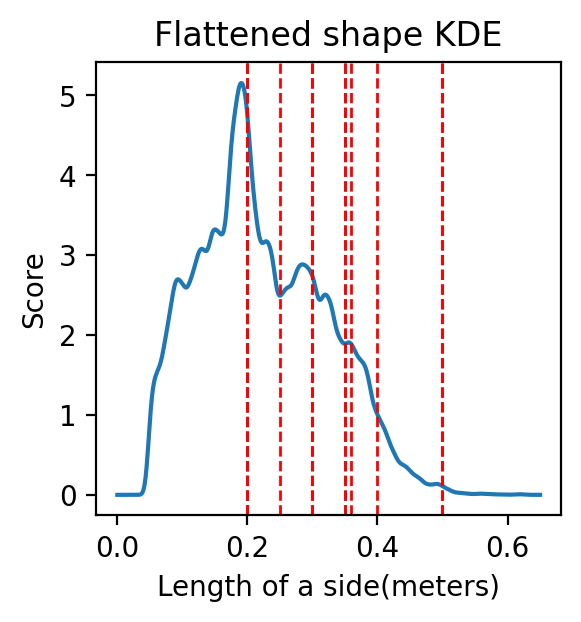

In [600]:
%matplotlib inline
# Get flattened shape and scores
flat_shapes = S_history.flatten()
flat_scores = np.tile(score_history[:, np.newaxis], (1, 3)).flatten()
kde = gaussian_kde(flat_shapes, weights=flat_scores, bw_method=0.05)
plt.figure(figsize=(3, 3), dpi=200)
xi = np.linspace(0., 0.65, 1000)
z = kde(xi)
plt.plot(xi, z)
for v in expected_sizes.flatten():
    plt.axvline(v, c="red", linestyle="--", linewidth=1)
plt.title("Flattened shape KDE")
plt.xlabel("Length of a side(meters)")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

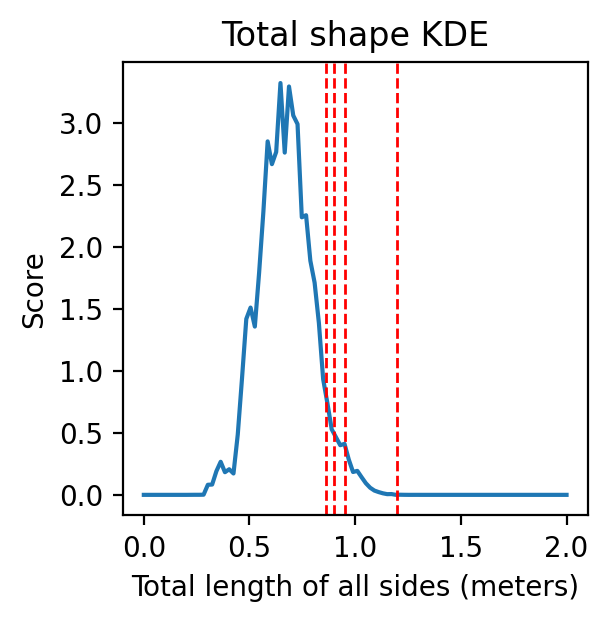

In [598]:
%matplotlib inline
# Get flattened shape and scores
kde = gaussian_kde(np.sum(S_history, axis=1), weights=score_history, bw_method=0.01)
plt.figure(figsize=(3, 3), dpi=200)
xi = np.linspace(0., 2.0, 100)
z = kde(xi)
plt.plot(xi, z)
for v in np.sum(expected_sizes, axis=1):
    plt.axvline(v, c="red", linestyle="--", linewidth=1)
plt.title("Total shape KDE")
plt.xlabel("Total length of all sides (meters)")
plt.ylabel("Score")

Text(0.5, 1.0, 'Sum of Normal fits to each cluster')

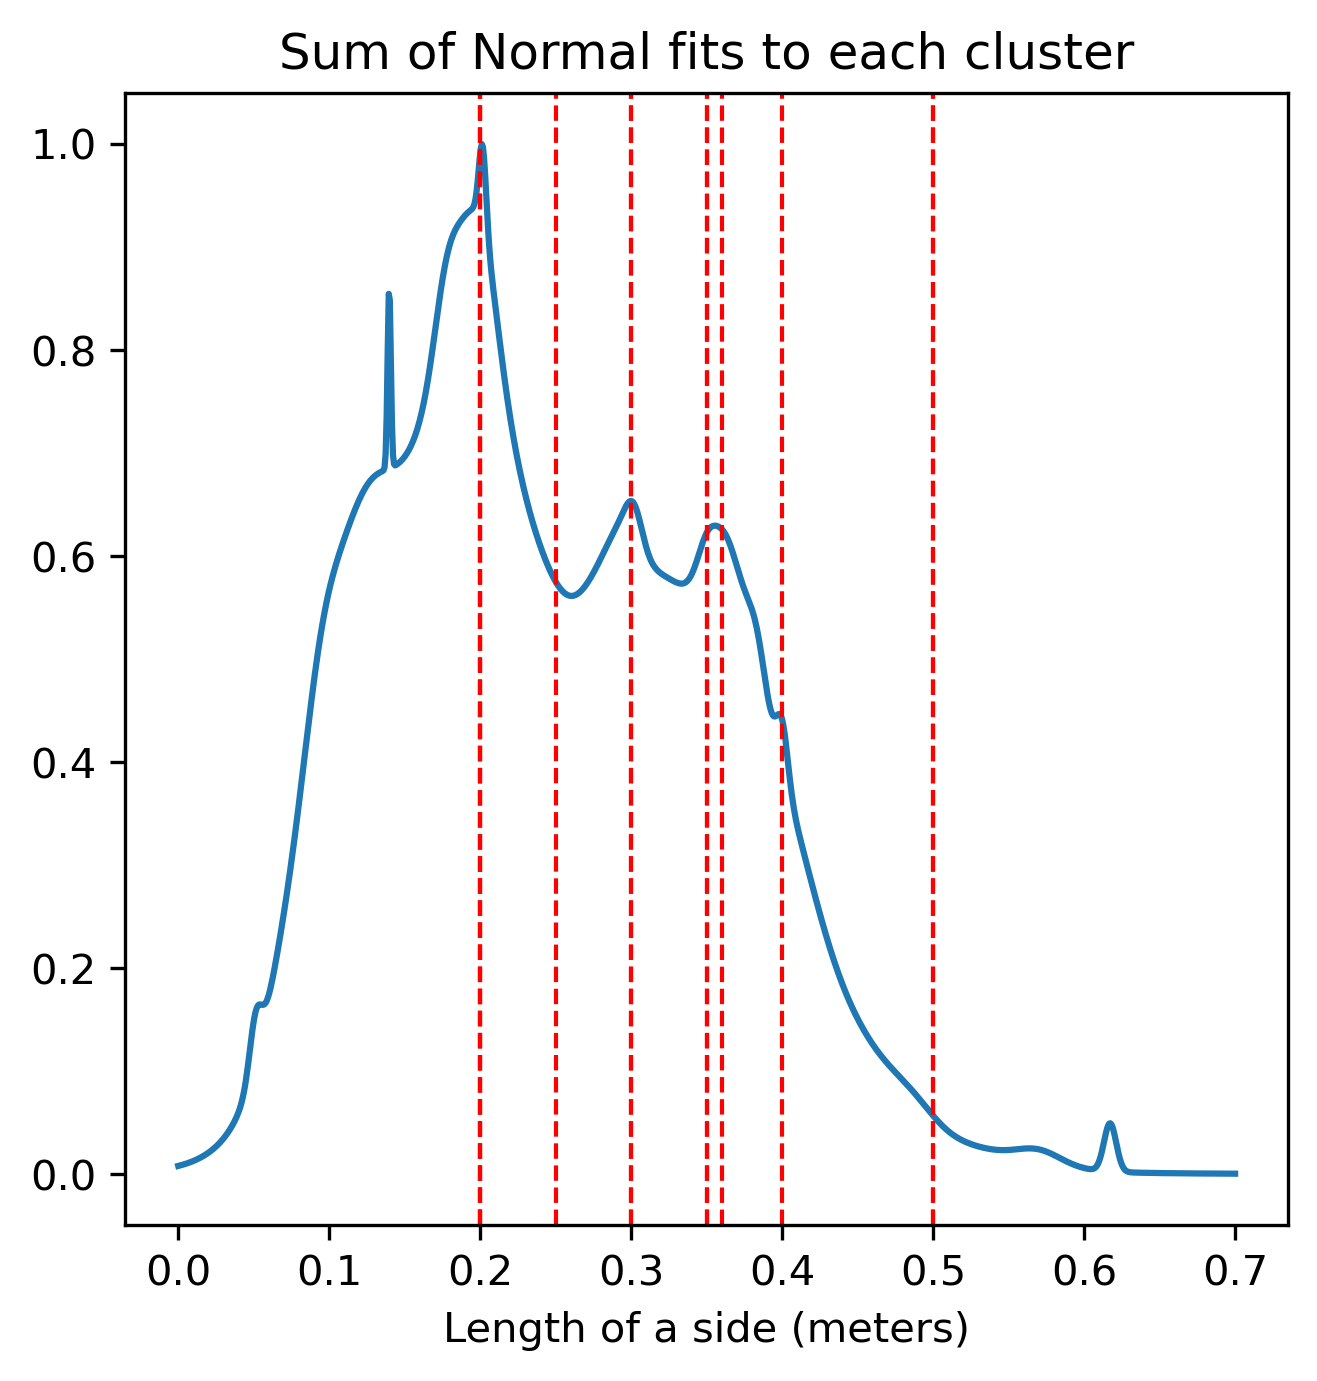

In [601]:
# For every cluster, compute 
xi = np.linspace(0, 0.7, 1000)
total_x = np.zeros((3, 1000))

plt.figure(dpi=300).set_size_inches(5, 5)
c = ['r', 'g', 'b']
for cluster_k in range(max(useful_cluster_indices)):
    these_inds = (useful_cluster_indices == cluster_k)
    if torch.sum(these_inds) == 0:
        continue
    # Take the top 100 of this cluster + fit Multivariate gaussian to it
    these_scores = useful_scores[these_inds]
    these_shapes = useful_Ss[these_inds]
    best_score_inds = torch.argsort(these_scores)[-50:]
    S = these_shapes[best_score_inds].numpy()
    S = np.sort(S, axis=1)
    mean = np.mean(S, axis=0)
    cov = np.cov(S.T)
    import scipy.stats as stats
    if np.all(np.isfinite(mean)) and np.all(np.isfinite(cov)):
        for k in range(3):
            vals = stats.multivariate_normal(mean[k], cov[k, k]).pdf(xi)
            total_x[k, :] += vals
            #plt.plot(xi, vals/np.max(vals)/5., c=c[k], alpha=0.1, linewidth=1.0)

import scipy as sp
#for k in range(3):
#    plt.plot(xi, total_x[k, :])
total_vals = np.sum(total_x, axis=0)
plt.plot(xi, total_vals / np.max(total_vals))
for x in expected_sizes.flatten():
    plt.axvline(x, c="r", linestyle="--", linewidth=1.0)
plt.xlabel("Length of a side (meters)")
plt.title("Sum of Normal fits to each cluster")

# for presentation figure
#desired_peaks = expected_sizes.flatten() #, axis=1)
#def desired_shape_dist_func(x):
#    val = 0.
#    for peak in desired_peaks:
#        val += sp.stats.norm(loc=peak, scale=0.005).pdf(x)
#    return val
#z = desired_shape_dist_func(xi)
#z /= (np.max(z)*5)
#plt.plot(xi, z)

In [495]:
# For every cluster, do k means

In [496]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(S_history, sample_weight=score_history)
print("KMeans center: ", kmeans.cluster_centers_)

from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, covariance_type="diag").fit(S_history)
print("GMM Means: ", gmm.means_)
print("GMM Vars: ", gmm.covariances_)


KMeans center:  [[0.35 0.26 0.2 ]
 [0.36 0.19 0.08]
 [0.26 0.17 0.09]
 [0.35 0.29 0.09]
 [0.48 0.2  0.1 ]]
GMM Means:  [[0.38 0.3  0.21]
 [0.23 0.17 0.12]
 [0.41 0.2  0.09]
 [0.32 0.23 0.13]
 [0.38 0.32 0.09]]
GMM Vars:  [[0.   0.   0.  ]
 [0.   0.   0.  ]
 [0.01 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
